# **TRAY FOOD SEGMENTATION**

This is a learning/exercise project to create an AI-computer vision model for image segmentation tasks. The dataset used is the Tray Food dataset obtained from [Kaggle](https://www.kaggle.com/datasets/thezaza102/tray-food-segmentation/data). Image segmentation can further be implemented in various industrial fields such as medical, automotive, robotics, agriculture, and many more.

## **Import Dependencies**

In [70]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchvision
import albumentations as albu # for data augmentation and preprocessing
from albumentations.pytorch import ToTensorV2

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# setting device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## **Loading Data**

In [3]:
# dataset directory
DATA_DIR = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset"
x_train_dir = os.path.join(DATA_DIR, "XTrain")
y_train_dir = os.path.join(DATA_DIR, "yTrain")

x_val_dir = os.path.join(DATA_DIR, "XVal")
y_val_dir = os.path.join(DATA_DIR, "yVal")

x_test_dir = os.path.join(DATA_DIR, "XTest")
y_test_dir = os.path.join(DATA_DIR, "yTest")

In [4]:
# count the dataset
count_x_train = len(os.listdir(x_train_dir))
count_y_train = len(os.listdir(y_train_dir))

count_x_val = len(os.listdir(x_val_dir))
count_y_val = len(os.listdir(y_val_dir))

count_x_test = len(os.listdir(x_test_dir))
count_y_test = len(os.listdir(y_test_dir))

print(f"Number of X train : {count_x_train}")
print(f"Number of y train : {count_y_train}\n")
print(f"Number of X val : {count_x_val}")
print(f"Number of y val : {count_y_val}\n")
print(f"Number of X test : {count_x_test}")
print(f"Number of y test : {count_y_test}")

Number of X train : 1217
Number of y train : 1217

Number of X val : 12
Number of y val : 12

Number of X test : 20
Number of y test : 20


In [5]:
CLASSES = ["background", "tray", "cutlery", "form", "straw", "meatball", "beef",
           "roastlamb", "beeftomatocasserole", "ham", "bean", "cucumber", "leaf",
           "tomato", "boiledrice", "beefmexicanmeatballs", "spinachandpumpkinrisotto",
           "bakedfish", "gravy", "zucchini", "carrot", "broccoli", "pumpkin", "celery",
           "sandwich", "sidesalad", "tartaresauce", "jacketpotato", "creamedpotato",
           "bread", "margarine", "soup", "apple", "cannedfruit", "milk", "vanillayogurt",
           "jelly", "custard", "lemonsponge", "juice", "applejuice", "orangejuice", "water"]

In [6]:
print(f"Number of Classes : {len(CLASSES)}")

Number of Classes : 43


### Load Custom Dataset

In [7]:
class TrayFood(Dataset):
    """
    TrayFood dataset, read image, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing (e.g. normalization, shape manipulation, etc.)

    """

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        # get images (X) and masks (y) ids/filename
        self.ids_x = sorted(os.listdir(images_dir)) # get filenames of images
        self.ids_y = sorted(os.listdir(masks_dir)) # get filenames of masks

        # get images (x) and masks (y) full paths (fps)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_x]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids_y]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        print(f"Classes Index: {self.class_values}")
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.ids_x)

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. Beef)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
             sample = self.preprocessing(image=image, mask=mask)
             image, mask = sample["image"], sample["mask"]

        return image, mask

In [8]:
trayfood_ds = TrayFood(x_test_dir, y_test_dir, classes=CLASSES)

Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [9]:
def visualize(image, mask, label=None, truth=None, augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title("Original Image")
        else:
            plt.title("Mask")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")
        plt.axis("off")

        plt.show()

In [10]:
# checking each class
for label in CLASSES:
    trayfood_ds = TrayFood(x_test_dir, y_test_dir, classes=[label])
    image, mask = trayfood_ds[8]
    visualize(image=image,
              mask=mask.squeeze(),
              label=label)
    print(" ")

Output hidden; open in https://colab.research.google.com to view.

### Data Augmentation and Preprocessing using Albumentations

In [11]:
# augmentation for data train using albumentations
def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 416, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.OneOf([albu.RandomBrightnessContrast(brightness_limit=0.4,
                                                  contrast_limit=0.4,
                                                  p=1),
                    albu.CLAHE(p=1),
                    albu.HueSaturationValue(p=1)], p=0.9),
        albu.GaussNoise(p=0.2)
    ]

    return albu.Compose(train_transform)

# augmentation for data validation using albumentations
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
        albu.PadIfNeeded(256, 416)
    ]

    return albu.Compose(val_transform)

# setting preprocessing
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]

    return albu.Compose(_transform)

In [12]:
# helper function for data visualization of augmentation
def visualizeData(**images):
    """Plot images in a row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

Classes Index: [1]


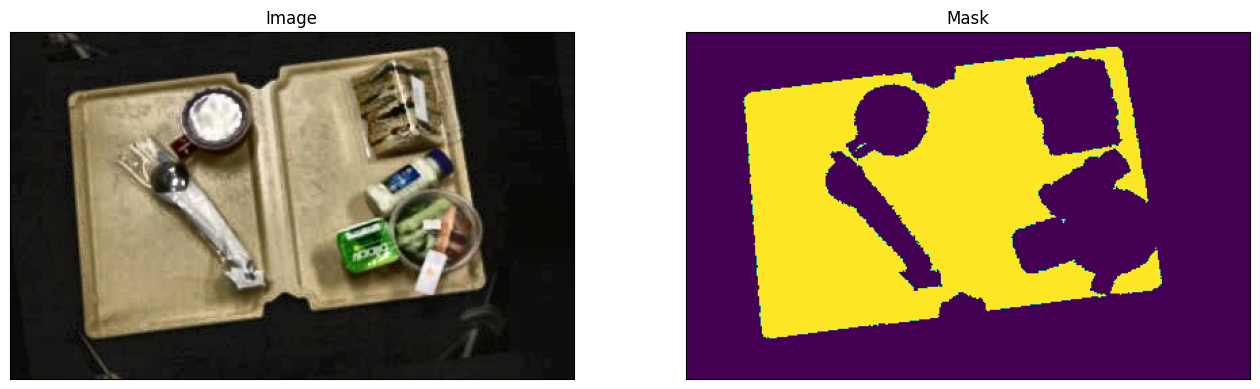

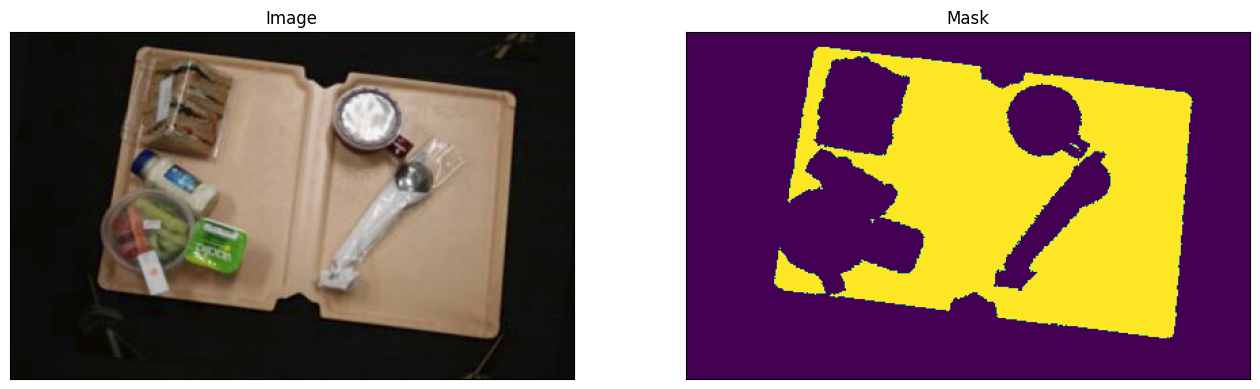

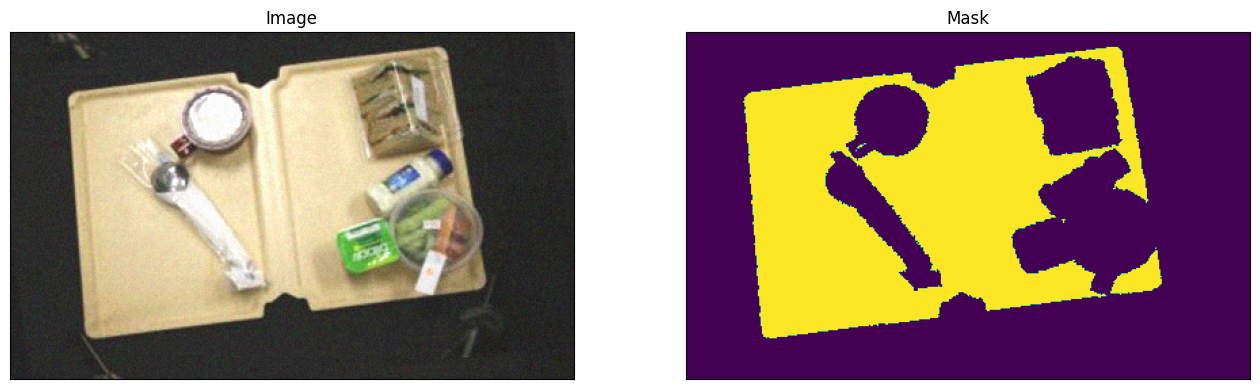

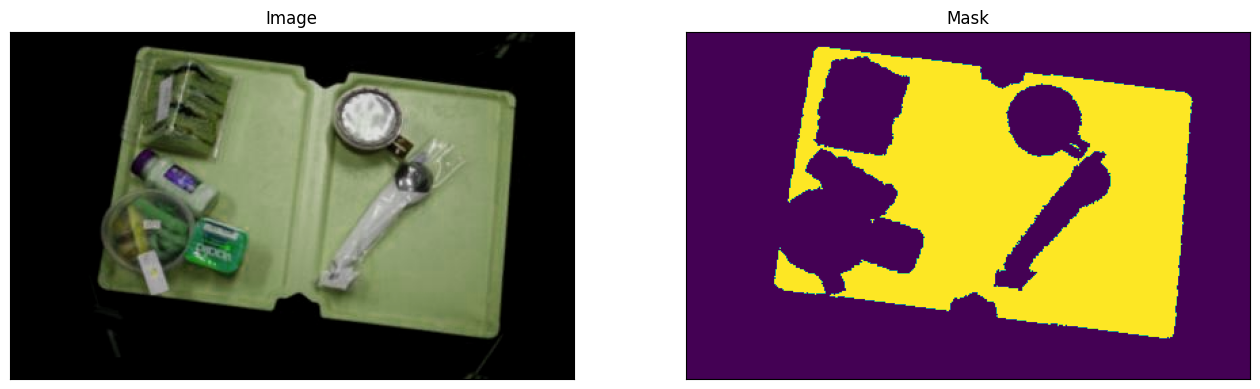

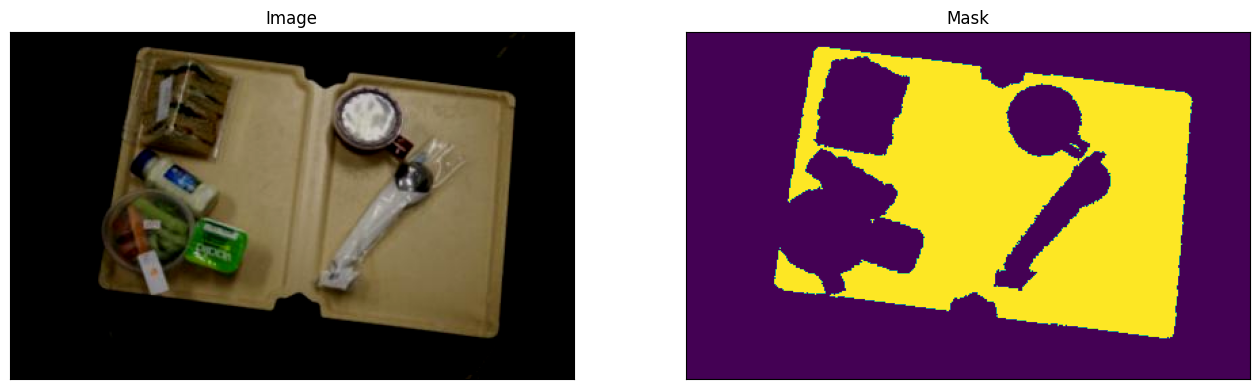

In [13]:
# apply to custom dataset class
augmented_dataset = TrayFood(x_test_dir,
                             y_test_dir,
                             classes=["tray"],
                             augmentation=get_training_augmentation())

# visualize data augmentation
for i in range(5):
    image, mask = augmented_dataset[10]
    visualizeData(image=image, mask=mask.squeeze(-1))

## **Defining Model**

### Clone SMP (Segmentation Model Pytorch) from GitHub

In [14]:
# install and clone github segmentation models pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-n9nk2wjd
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-n9nk2wjd
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 3d6da1d74636873372c265f300862a6a6d01777d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cac

In [15]:
!pip install torchsummary

In [16]:
import segmentation_models_pytorch as smp
from torchsummary import summary

### UNet

In [17]:
# encoder use resnet50
ENCODER = "resnet50"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax"

# decoder use unet
model_unet = smp.Unet(encoder_name=ENCODER,
                      encoder_weights=ENCODER_WEIGHTS,
                      classes=len(CLASSES),
                      activation=ACTIVATION)

# normalize your data the same way as during encoder weight pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


In [21]:
# model summary
summary(model_unet.to(DEVICE), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


## **Defining Metric Performance, Optimizer, and Loss Function**

In [23]:
import re

class BaseObject(nn.Module):
    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", name)
            return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()
        else:
            return self._name

class Metric(BaseObject):
    pass

class Loss(BaseObject):
    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError("Loss should be inherited from `Loss` class")

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError("Loss should be inherited from `BaseLoss` class")

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):
    def __init__(self, l1, l2):
        name = "{} + {}".format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)

class MultipliedLoss(Loss):
    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split("+")) > 1:
            name = "{} * ({})".format(multiplier, loss.__name__)
        else:
            name = "{} * {}".format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)

In [24]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs

def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x

def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union

jaccard = iou

def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score

def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score

def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score

def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [25]:
class JaccardLoss(Loss):
    def __init__(self, eps=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

class DiceLoss(Loss):
    def __init__(self, eps=1.0, beta=1.0, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr,
            y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )

class L1Loss(nn.L1Loss, Loss):
    pass

class MSELoss(nn.MSELoss, Loss):
    pass

class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass

class NLLLoss(nn.NLLLoss, Loss):
    pass

class BCELoss(nn.BCELoss, Loss):
    pass

class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

In [26]:
class IoU(Metric):
    __name__ = "iou_score"

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Fscore(Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Accuracy(Metric):
    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr,
            y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Recall(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return recall(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

class Precision(Metric):
    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return precision(
            y_pr,
            y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [27]:
metrics = [
    IoU(threshold=0.5),
    Accuracy(threshold=0.5),
    Fscore(threshold=0.5),
    Recall(threshold=0.5),
    Precision(threshold=0.5),
]

In [28]:
# optimizer use adam
optimizer = torch.optim.Adam([dict(params=model_unet.parameters(), lr=0.0001)])

# define loss function
loss_fn = DiceLoss()

## **Training Preparation**

### DataLoader

In [29]:
train_dataset = TrayFood(x_train_dir,
                         y_train_dir,
                         augmentation=get_training_augmentation(),
                         preprocessing=get_preprocessing(preprocessing_fn),
                         classes=CLASSES)

validation_dataset = TrayFood(x_val_dir,
                              y_val_dir,
                              augmentation=get_validation_augmentation(),
                              preprocessing=get_preprocessing(preprocessing_fn),
                              classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


### Training Function

In [30]:
class Meter(object):
    """Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    """

    def reset(self):
        """Reset the meter to default settings."""
        pass

    def add(self, value):
        """Log a new value to the meter
        Args:
            value: Next result to include.
        """
        pass

    def value(self):
        """Get the value of the meter in the current state."""
        pass

class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [31]:
import sys
from tqdm import tqdm as tqdm

class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs

class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [32]:
train_epoch = TrainEpoch(
    model_unet,
    loss=loss_fn,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model_unet,
    loss=loss_fn,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

## **Training Process**

In [35]:
max_score = 0

for i in range(0, 10):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(validation_loader)


Epoch: 0
valid: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s, dice_loss - 0.2144, iou_score - 0.8179, accuracy - 0.9956, fscore - 0.8997, recall - 0.8458, precision - 0.961]

Epoch: 1
valid: 100%|██████████| 12/12 [00:02<00:00,  5.60it/s, dice_loss - 0.1656, iou_score - 0.8307, accuracy - 0.9959, fscore - 0.9074, recall - 0.8556, precision - 0.966]

Epoch: 2
valid: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s, dice_loss - 0.1502, iou_score - 0.8281, accuracy - 0.9958, fscore - 0.9059, recall - 0.8608, precision - 0.9559]

Epoch: 3
valid: 100%|██████████| 12/12 [00:02<00:00,  5.96it/s, dice_loss - 0.1447, iou_score - 0.8363, accuracy - 0.9961, fscore - 0.9108, recall - 0.8607, precision - 0.9671]

Epoch: 4
valid: 100%|██████████| 12/12 [00:02<00:00,  5.41it/s, dice_loss - 0.1427, iou_score - 0.8343, accuracy - 0.996, fscore - 0.9096, recall - 0.8609, precision - 0.9641]

Epoch: 5
valid: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s, dice_loss - 0.1408, iou_score - 0.8334, accuracy

## **Save Model Trained**

In [37]:
torch.save(model_unet.state_dict(), "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset/TrayFood_UNet.pth")

## **Making Prediction**

In [64]:
test_dataset = TrayFood(x_test_dir,
                        y_test_dir,
                        augmentation=None,
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Classes Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [65]:
trained_model = smp.Unet(encoder_name="resnet50",
                         encoder_weights=None,
                         in_channels=3,
                         classes=len(CLASSES)).to(DEVICE)

# load state dict dari Google Drive
model_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset/TrayFood_UNet.pth"
trained_model.load_state_dict(torch.load(model_path))
trained_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [74]:
def predict_image(image_path, model, device):
    # read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image preprocessing
    preprocess = albu.Compose([
        albu.Resize(256, 256),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    augmented = preprocess(image=image)
    image_tensor = augmented["image"].unsqueeze(0).to(device)

    # prediction
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output).cpu().numpy()[0][0]  # Konversi ke numpy dan ambil channel pertama

    # thresholding for binary mask
    threshold = 0.5
    output = (output > threshold).astype(np.uint8)

    # show original image and segmented image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output, cmap="gray")
    plt.title("Segmented Image")
    plt.axis("off")

    plt.show()

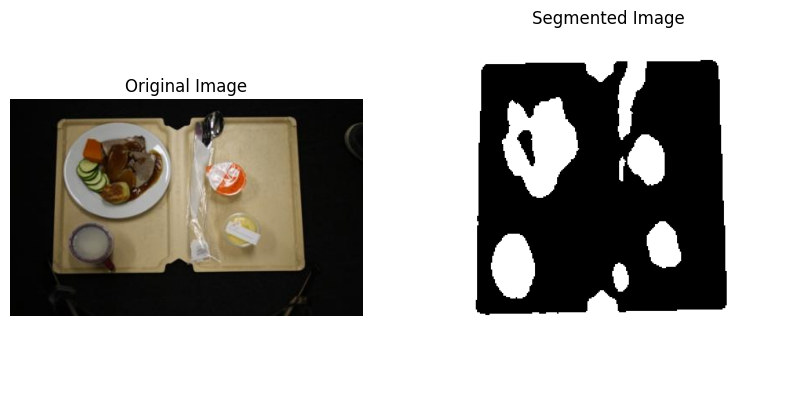

In [75]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset/XTest/1001a01.jpg"
predict_image(image_path, trained_model, DEVICE)

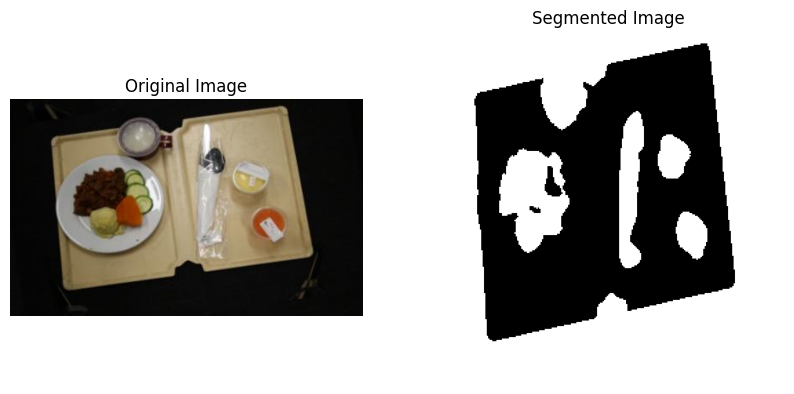

In [76]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset/XTest/2001a72.jpg"
predict_image(image_path, trained_model, DEVICE)

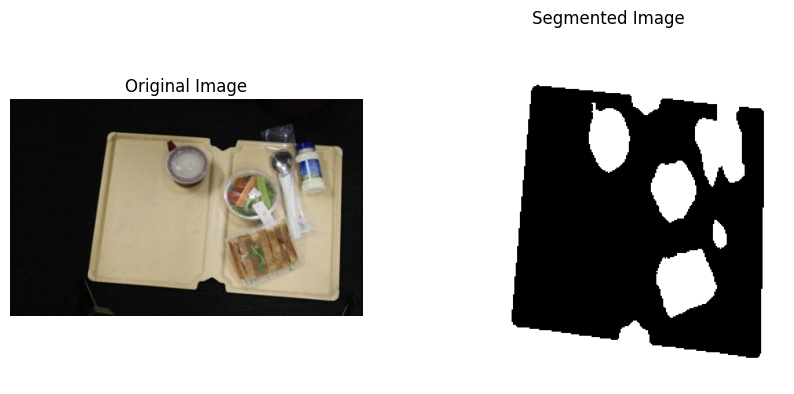

In [77]:
image_path = "/content/drive/MyDrive/Dataset/project_cv_4_SemanticSegmentation/TrayDataset/XTest/5006a.jpg"
predict_image(image_path, trained_model, DEVICE)